### DPCN Team Baby Sharks Project
- Amey Choudhary
- Aryan Gupta
- Keshav Gupta

# SSA

In [4]:
# Modular code from here

# Flow of the pipeline
# 1. Read the data
# 2. Perform Signal Decomposition
# 3. Train the models
# 4. Forecast the results

In [5]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as  nn
import torch.optim as optim
import torch

In [6]:
# Selecting the dataset. Change the file path and type of data .manual
file_path ="./Datasets/Malaria_datasets/Venezuela_Malaria.xlsx"

# Reading the data
dataset = pd.read_excel(file_path)

print("The shape of the dataset: ", dataset.shape)
print("The first 5 entries are:" )
print(dataset.head())


The shape of the dataset:  (669, 2)
The first 5 entries are:
   Weeks  Cases
0      1    588
1      2    635
2      3    405
3      4    425
4      5    452


In [7]:
location = file_path.split("/")[-1].split("_")[0]
disease = file_path.split("/")[-1].split("_")[1].split(".")[0]

# selecting the hyperparameters for the dataset from excel
hyperparameters = pd.read_excel("./Suggested hyper-parameter values of EWNet model.xlsx")

# finding the hyperparameters for the dataset
for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break

# type of dataset as in weekly or monthly. need to set this manual after looking at the dataset values
type_of_dataset = "Weekly" # "Weekly" or "Monthly

# select the index of time, manual
index_of_cases = 1

# select the forecast type manual
forecast_type = "Medium" # "Short" or "Medium" or "Long"

p = hyperparameters[forecast_type][hyperparameters_index]
k = (p+1)//2

pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}

if type_of_dataset == "Weekly":
    pred_length = pred_length_weekly[forecast_type]
else:
    pred_length = pred_length_monthly[forecast_type]

test_size = pred_length
valid_size = 2*pred_length
train_size = dataset.shape[0] - test_size - valid_size-p # p is the lag, so train size wont contain the first p values


print("The value of p:",p)
print("The value of k:", k)
print("The prediction length is:", pred_length)



The value of p: 12
The value of k: 6
The prediction length is: 26


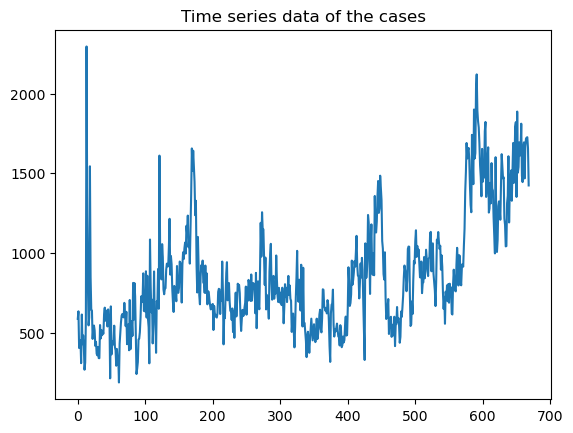

In [8]:
# changing to time series data
cases_time_series = dataset.iloc[:, index_of_cases].values
plt.plot(cases_time_series)
plt.title("Time series data of the cases")
plt.show()

In [9]:
cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

# scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)


In [10]:
# performing signal decomposition
from pyts.decomposition import SingularSpectrumAnalysis

window_size = np.floor(np.log(len(cases_time_series_scaled))).astype(int) # as in paper
ssa = SingularSpectrumAnalysis(window_size=window_size)

# Fit and transform the data using SSA
IMFs = ssa.fit_transform(cases_time_series_scaled.reshape(1, -1))

# print(IMFs.shape)
IMFs = IMFs.reshape(window_size,-1)
n_imfs = IMFs.shape[0]

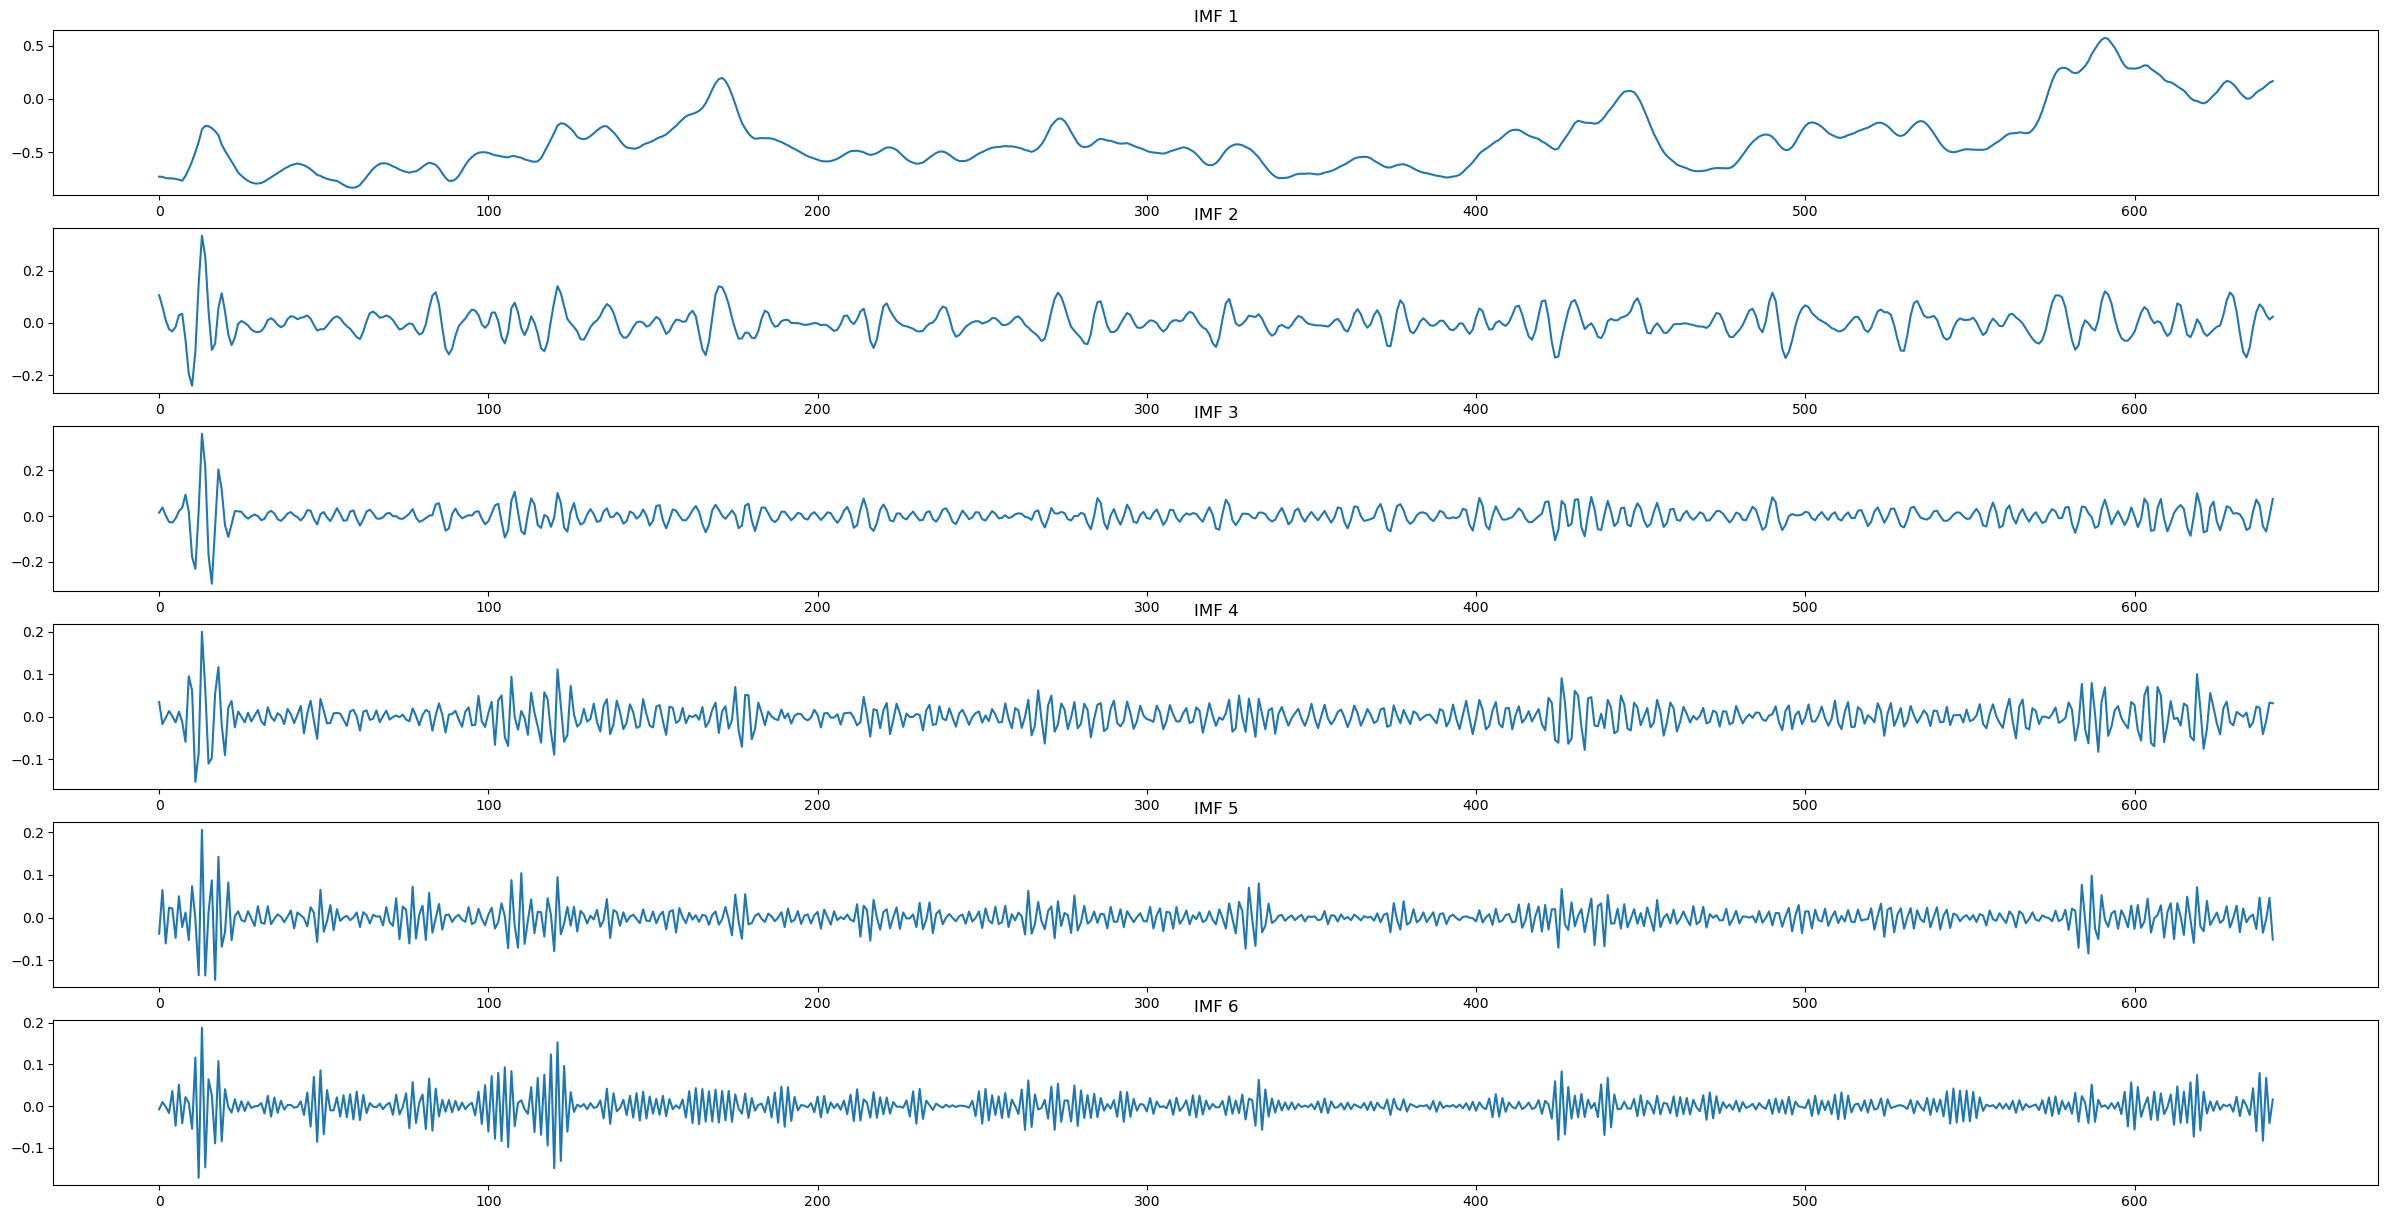

In [11]:
# plotting the IMFs
plt.figure(figsize=(30, 15))
for i in range(n_imfs):
    plt.subplot(n_imfs, 1, i+1)
    plt.plot(IMFs[i, :])
    plt.title("IMF "+str(i+1))
plt.show()


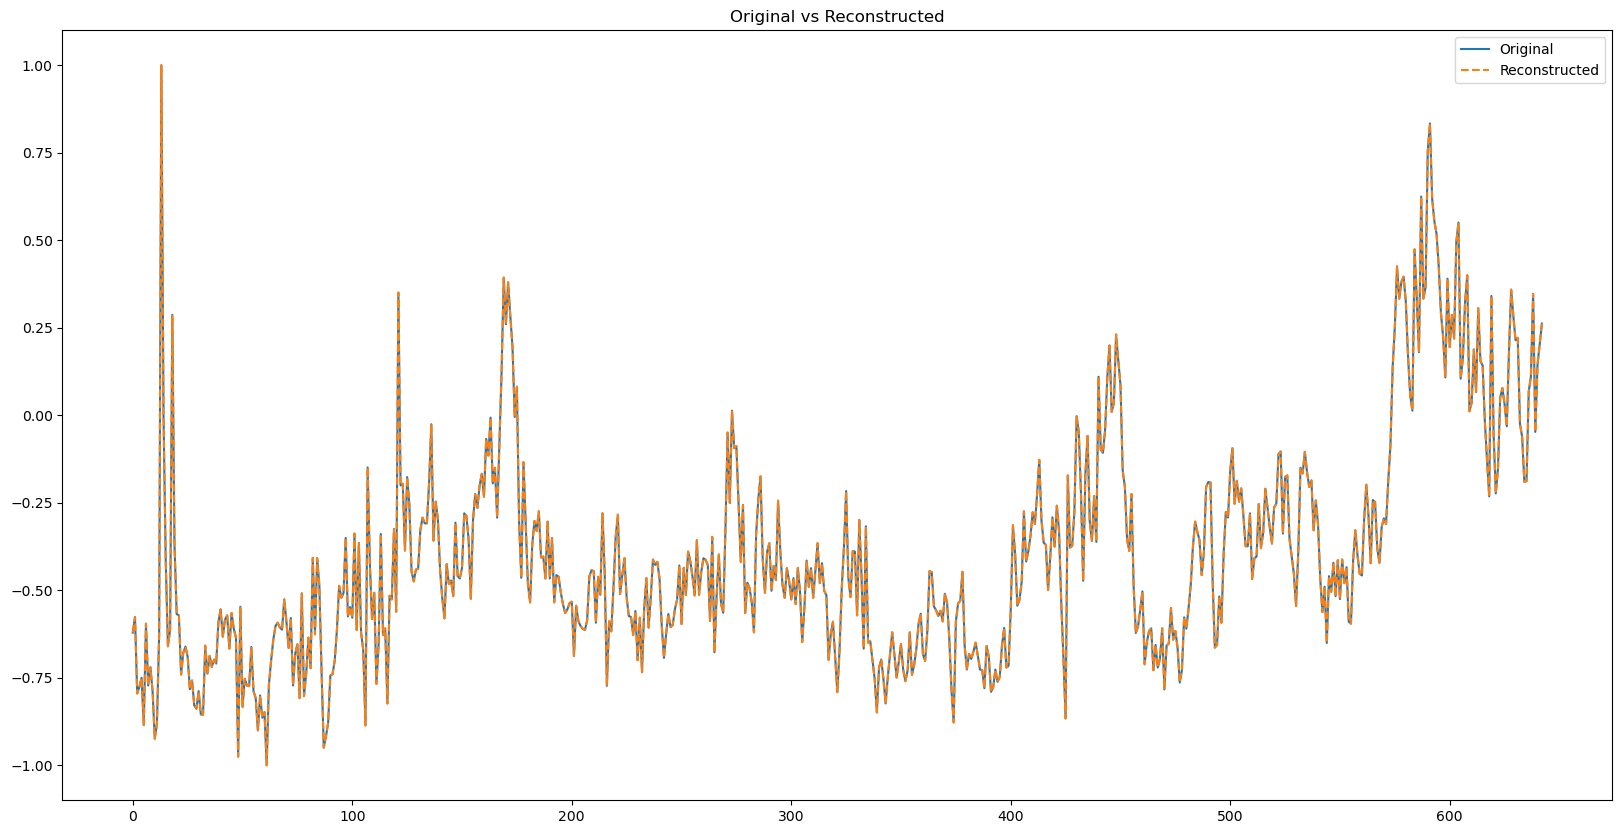

In [12]:
# checking the IMFs and actual
reconstructed_time_series = IMFs.sum(axis=0)
plt.figure(figsize=(20, 10))
plt.plot(cases_time_series_scaled, label="Original" )
plt.plot(reconstructed_time_series, label="Reconstructed", linestyle="--")
plt.title("Original vs Reconstructed")
plt.legend()
plt.show()

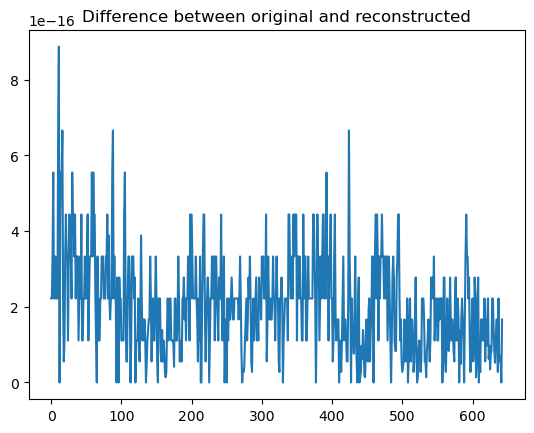

In [13]:
difference = np.abs(reconstructed_time_series - cases_time_series_scaled)
plt.plot(difference)
plt.title("Difference between original and reconstructed")
plt.show()

clearly the decomposition is done well

In [14]:
# creating the class for neural network
class EWNet(nn.Module):
    def __init__(self, p, k):
        super(EWNet, self).__init__()
        self.fc1 = nn.Linear(p, k)
        self.fc2 = nn.Linear(k, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


In [15]:
# creating the train dataset and test dataset

# Define function to create lagged sequences
def create_lagged_sequence(data, lag):
    X, y = [], []
    for i in range(len(data)-lag):
        X.append(data[i:(i+lag)])
        y.append(data[i+lag])
    return np.array(X), np.array(y)



X_train = []
y_train = []
X_valid = []
y_valid = []

for i in range(n_imfs):
    X, y = create_lagged_sequence(IMFs[i], p)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    X_train.append(X[0:train_size])
    y_train.append(y[0:train_size])
    X_valid.append(X[train_size:train_size+valid_size])
    y_valid.append(y[train_size:train_size+valid_size])



In [16]:
print("The shape of X_train[0]:", X_train[0].shape)
print("The shape of y_train[0]:", y_train[0].shape)
print("The shape of X_valid[0]:", X_valid[0].shape)
print("The shape of y_valid[0]:", y_valid[0].shape)

The shape of X_train[0]: torch.Size([579, 12])
The shape of y_train[0]: torch.Size([579])
The shape of X_valid[0]: torch.Size([52, 12])
The shape of y_valid[0]: torch.Size([52])


Training started for model:  1
Epoch:  0 Training Loss:  1.3257851600646973 Validation Loss:  0.259064257144928
Epoch:  1000 Training Loss:  0.020164288580417633 Validation Loss:  0.046101029962301254
Epoch:  2000 Training Loss:  0.009761280380189419 Validation Loss:  0.00739919301122427
Epoch:  3000 Training Loss:  0.00428635161370039 Validation Loss:  0.0042176758870482445
Epoch:  4000 Training Loss:  0.002314596436917782 Validation Loss:  0.0032301603350788355
Epoch:  5000 Training Loss:  0.0012453868985176086 Validation Loss:  0.002856668084859848
Epoch:  6000 Training Loss:  0.0008068238967098296 Validation Loss:  0.002322892192751169
Epoch:  7000 Training Loss:  0.0004787642683368176 Validation Loss:  0.0013937060721218586
Epoch:  8000 Training Loss:  0.00030245844391174614 Validation Loss:  0.0007966766715981066
Epoch:  9000 Training Loss:  0.00024082027084659785 Validation Loss:  0.000604633241891861
Training completed for model:  1
Training started for model:  2
Epoch:  0 Trai

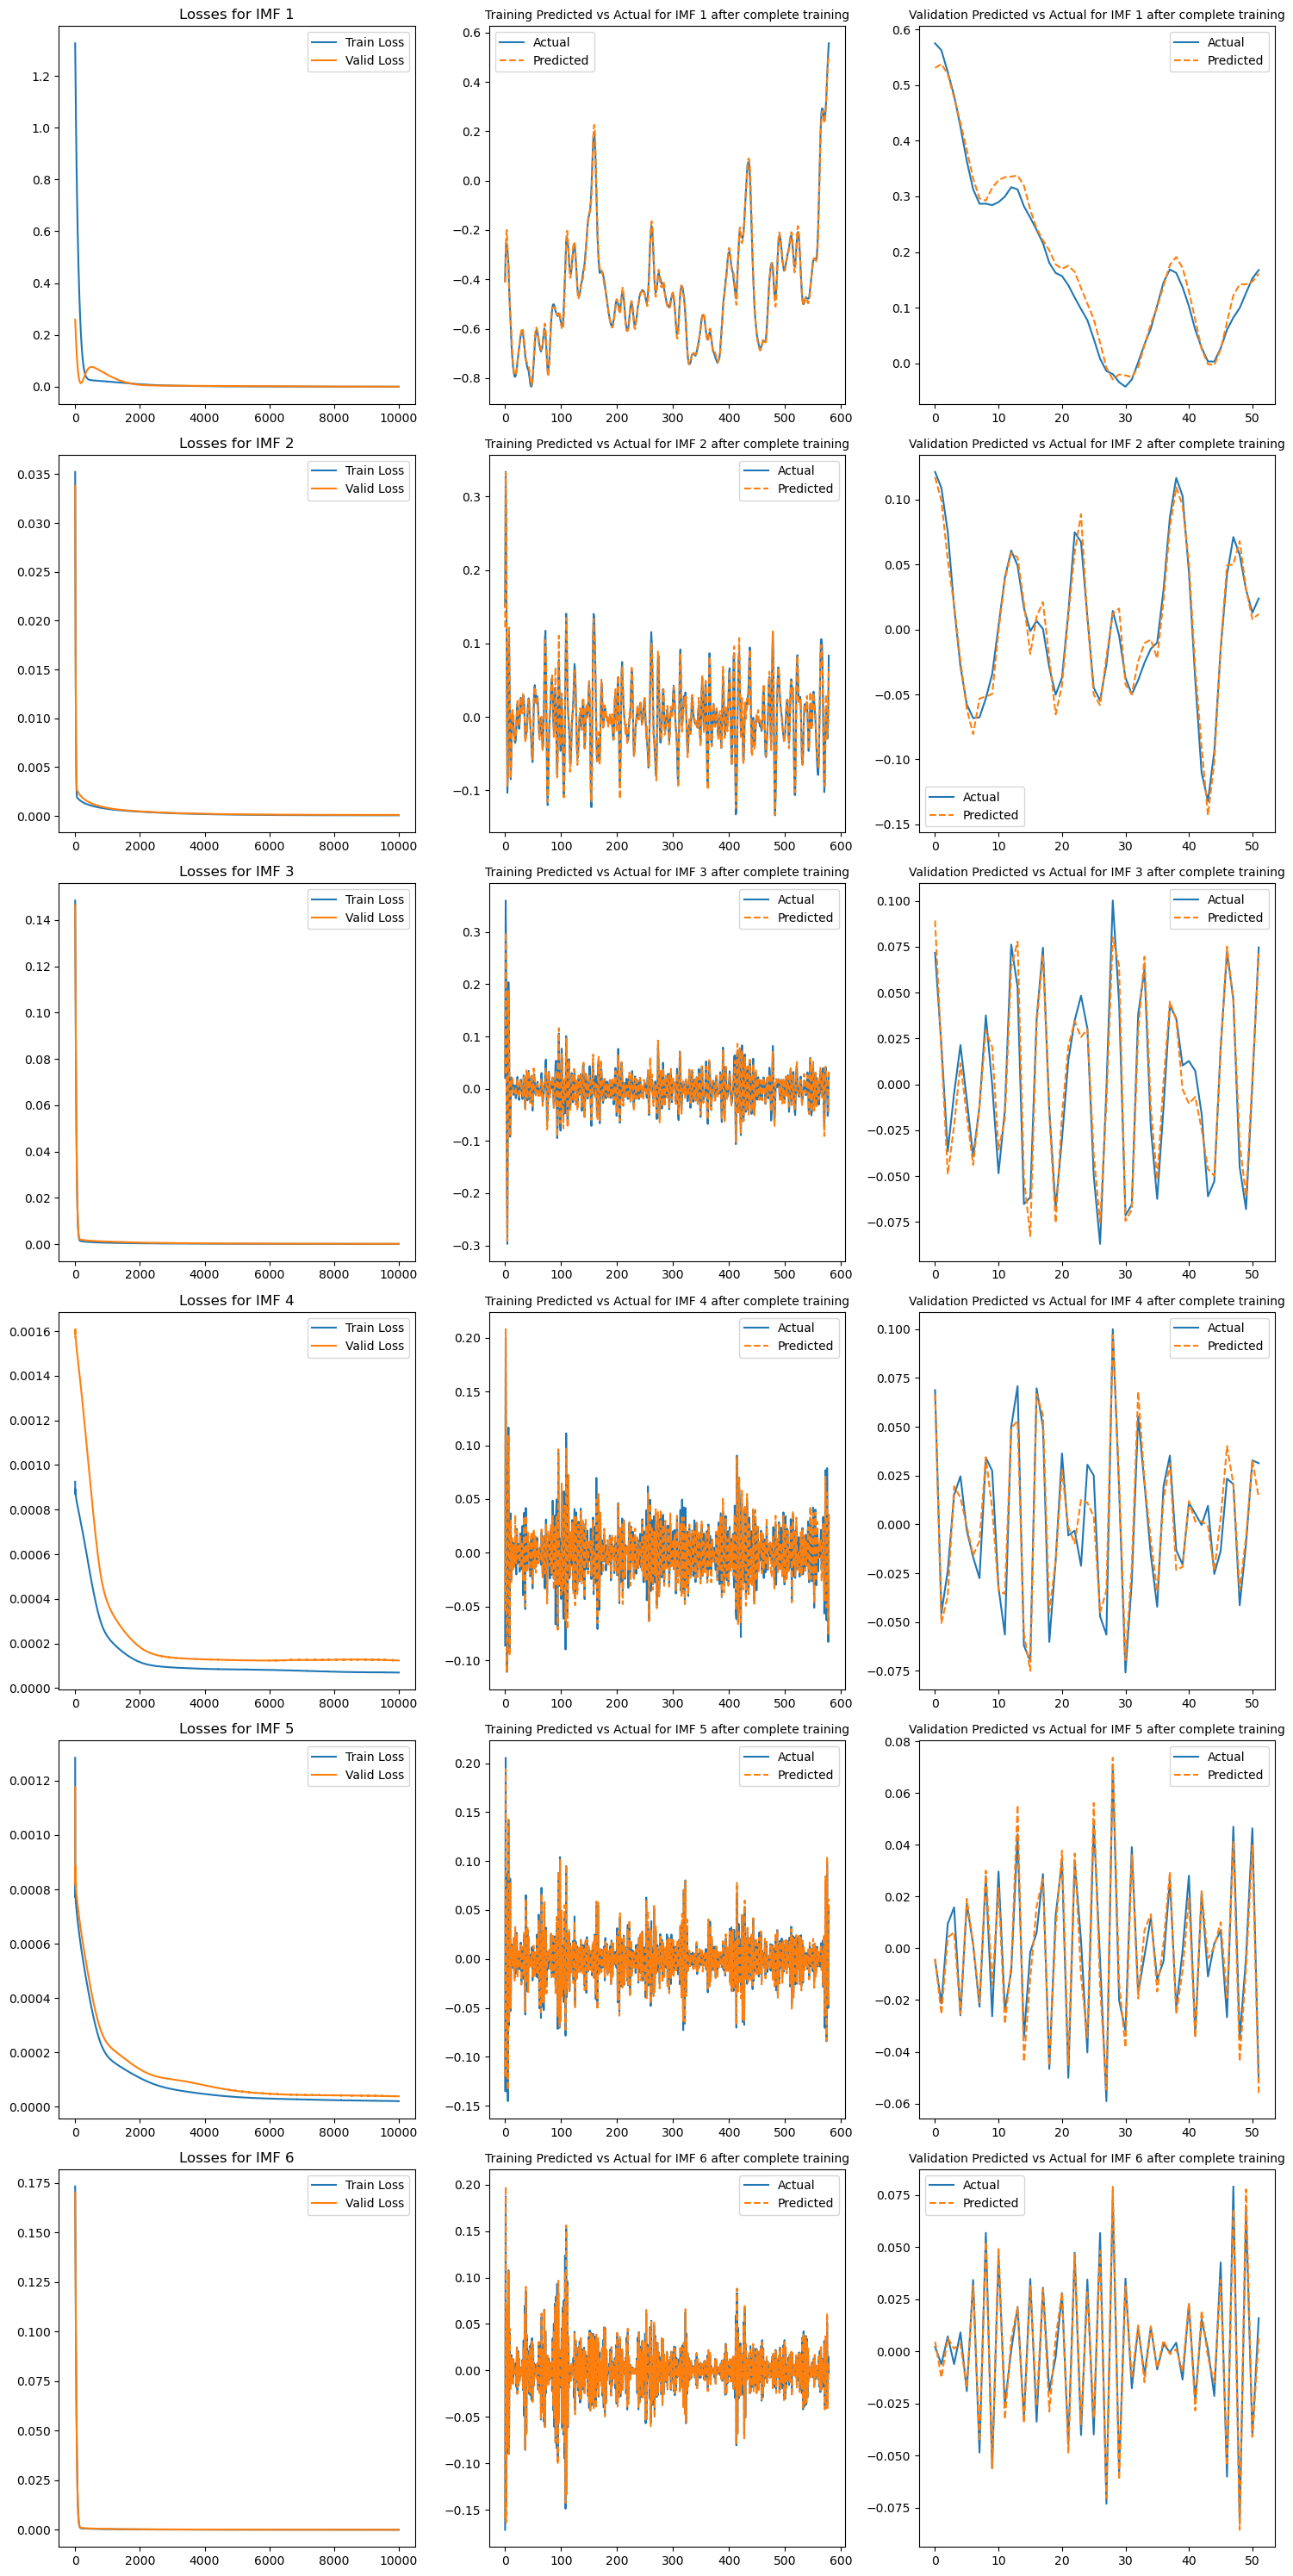

In [17]:
# running the model
n_models = []

fig, axes = plt.subplots(n_imfs, 3, figsize=(15, 5*n_imfs))

for i in range(n_imfs):

    # initializing the model
    model = EWNet(p, k)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10000
    print_freq = 10
    epoch_freq = epochs//print_freq
    train_losses = []
    valid_losses = []

    print("Training started for model: ", i+1)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_train_pred = model(X_train[i])
        y_train_pred = y_train_pred.view(-1)
        loss = criterion(y_train_pred, y_train[i])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        with torch.no_grad():
            model.eval()
            y_valid_pred = model(X_valid[i])
            y_valid_pred = y_valid_pred.view(-1)
            valid_loss = criterion(y_valid_pred, y_valid[i])
            valid_losses.append(valid_loss.item())
        if epoch % epoch_freq == 0:
            print("Epoch: ", epoch, "Training Loss: ", loss.item(), "Validation Loss: ", valid_loss.item())
    print("Training completed for model: ", i+1)

    # Saving the model
    n_models.append(model)

    # Plot training and validation losses
    axes[i, 0].plot(train_losses, label="Train Loss")
    axes[i, 0].plot(valid_losses, label="Valid Loss")
    axes[i, 0].set_title("Losses for IMF "+str(i+1))
    axes[i, 0].legend()

    # Plotting the predicted vs actual for training
    axes[i, 1].plot(y_train[i], label="Actual")
    axes[i, 1].plot(y_train_pred.detach().numpy(), label="Predicted", linestyle="--")
    axes[i, 1].set_title("Training Predicted vs Actual for IMF "+str(i+1) + " after complete training" , fontsize=10)
    axes[i, 1].legend()

    # Plotting the predicted vs actual for validation
    axes[i, 2].plot(y_valid[i], label="Actual")
    axes[i, 2].plot(y_valid_pred.detach().numpy(), label="Predicted", linestyle="--")
    axes[i, 2].set_title("Validation Predicted vs Actual for IMF "+str(i+1) + " after complete training", fontsize=10)
    axes[i, 2].legend()

plt.tight_layout()
plt.show()


In [18]:
# testing the models
y_test_pred_final = []

for i in range(n_imfs):
    initial_input = IMFs[i][ -p:]
    y_test_pred_imfs = []
    
    model = n_models[i]
    model.eval()    
    
    with torch.no_grad():
        for j in range(test_size):
            y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
            y_test_pred_imfs.append(y_pred.item())
            initial_input = np.append(initial_input, y_pred.item())
    

    y_test_pred_final.append(y_test_pred_imfs)


In [19]:
y_test_pred_final = np.array(y_test_pred_final)
y_test_pred_final = y_test_pred_final.sum(axis=0)
y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

The results are:
         RMSE         MAE      MASE     sMAPE
0  167.801077  131.968801  0.775557  8.318913


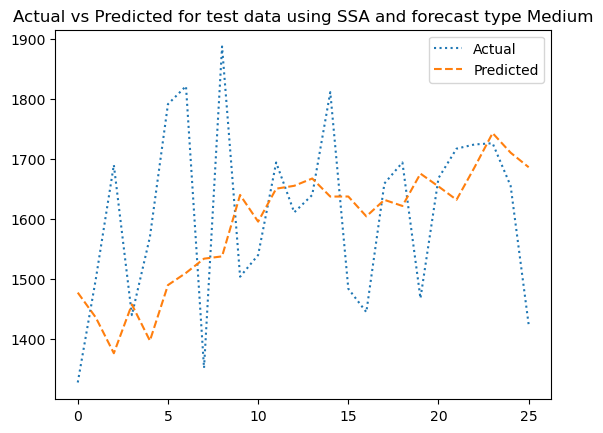

In [20]:
# calculating RMSE loss and  comparing the results
y_test_pred = np.array(y_test_pred_final)
y_test_true = np.array(cases_time_series[-test_size:])


# print("The RMSE loss is: ", np.sqrt(np.mean((y_test_pred - y_test_true)**2)))

rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
mae = np.mean(np.abs(y_test_pred - y_test_true))
mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))

# tabulate the results
results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
print("The results are:")
print(results)


plt.plot(y_test_true, label="Actual", linestyle= "dotted")
plt.plot(y_test_pred, label="Predicted", linestyle="--")
plt.title("Actual vs Predicted for test data using SSA and forecast type "+forecast_type)
plt.legend()
plt.show()

Training completed for model: time  Short  and IMF  1
Training completed for model: time  Short  and IMF  2
Training completed for model: time  Short  and IMF  3
Training completed for model: time  Short  and IMF  4
Training completed for model: time  Short  and IMF  5
Training completed for model: time  Short  and IMF  6
The results for forecast type  Short  are:
         RMSE         MAE      MASE      sMAPE
0  198.667891  178.105363  1.359583  11.339351


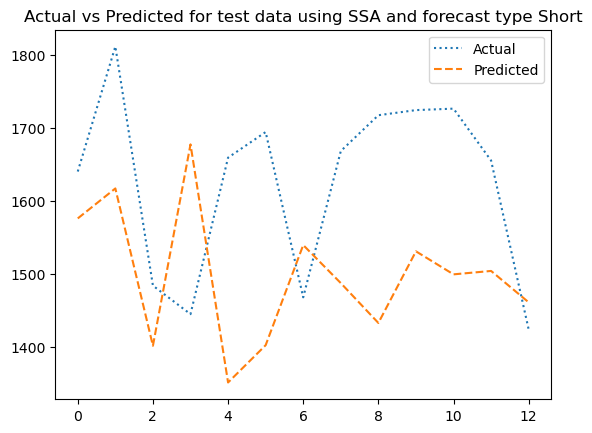

Training completed for model: time  Medium  and IMF  1
Training completed for model: time  Medium  and IMF  2
Training completed for model: time  Medium  and IMF  3
Training completed for model: time  Medium  and IMF  4
Training completed for model: time  Medium  and IMF  5
Training completed for model: time  Medium  and IMF  6
The results for forecast type  Medium  are:
         RMSE         MAE      MASE      sMAPE
0  297.677802  258.703245  1.520353  15.041557


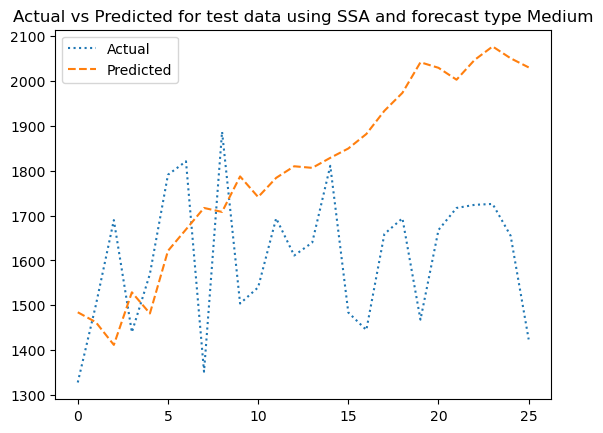

Training completed for model: time  Long  and IMF  1
Training completed for model: time  Long  and IMF  2
Training completed for model: time  Long  and IMF  3
Training completed for model: time  Long  and IMF  4
Training completed for model: time  Long  and IMF  5
Training completed for model: time  Long  and IMF  6
The results for forecast type  Long  are:
         RMSE         MAE      MASE      sMAPE
0  363.580102  313.763067  1.884574  22.873681


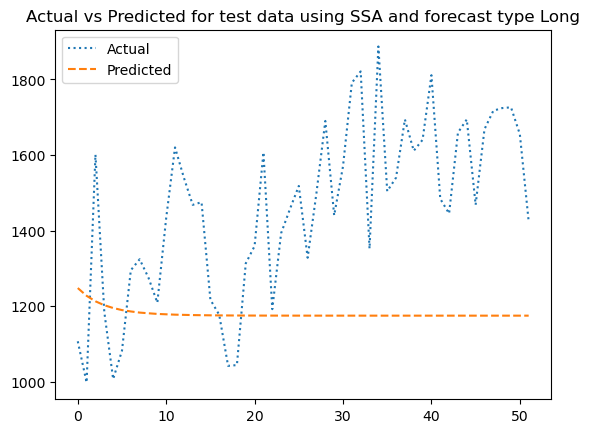

In [22]:
file_path = "./Datasets/Malaria_datasets/Venezuela_Malaria.xlsx"
location = file_path.split("/")[-1].split("_")[0]
disease = file_path.split("/")[-1].split("_")[1].split(".")[0]
dataset = pd.read_excel(file_path)

hyperparameters = pd.read_excel("./Suggested hyper-parameter values of EWNet model.xlsx")

for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break

type_of_dataset = "Weekly"

index_of_cases = 1

for time in ["Short", "Medium", "Long"]:
    p = hyperparameters[time][hyperparameters_index]
    k = (p+1)//2

    pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
    pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}

    if type_of_dataset == "Weekly":
        pred_length = pred_length_weekly[time]
    else:
        pred_length = pred_length_monthly[time]

    test_size = pred_length
    valid_size = 2*pred_length
    train_size = dataset.shape[0] - test_size - valid_size-p

    cases_time_series = dataset.iloc[:, index_of_cases].values

    cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)

    window_size = np.floor(np.log(len(cases_time_series_scaled))).astype(int)
    ssa = SingularSpectrumAnalysis(window_size=window_size)

    IMFs = ssa.fit_transform(cases_time_series_scaled.reshape(1, -1))

    IMFs = IMFs.reshape(window_size,-1)
    n_imfs = IMFs.shape[0]

    X_train = []
    y_train = []
    X_valid = []
    y_valid = []

    for i in range(n_imfs):
        X, y = create_lagged_sequence(IMFs[i], p)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        X_train.append(X[0:train_size])
        y_train.append(y[0:train_size])
        X_valid.append(X[train_size:train_size+valid_size])
        y_valid.append(y[train_size:train_size+valid_size])

    n_models = []

    for i in range(n_imfs):

        model = EWNet(p, k)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        epochs = 10000
        print_freq = 10
        epoch_freq = epochs//print_freq
        train_losses = []
        valid_losses = []

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            y_train_pred = model(X_train[i])
            y_train_pred = y_train_pred.view(-1)
            loss = criterion(y_train_pred, y_train[i])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            with torch.no_grad():
                model.eval()
                y_valid_pred = model(X_valid[i])
                y_valid_pred = y_valid_pred.view(-1)
                valid_loss = criterion(y_valid_pred, y_valid[i])
                valid_losses.append(valid_loss.item())

        n_models.append(model)
        print("Training completed for model: time ", time, " and IMF ", i+1)

    y_test_pred_final = []

    for i in range(n_imfs):
        initial_input = IMFs[i][ -p:]
        y_test_pred_imfs = []

        model = n_models[i]
        model.eval()

        with torch.no_grad():
            for j in range(test_size):
                y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
                y_test_pred_imfs.append(y_pred.item())
                initial_input = np.append(initial_input, y_pred.item())

        y_test_pred_final.append(y_test_pred_imfs)

    y_test_pred_final = np.array(y_test_pred_final)
    y_test_pred_final = y_test_pred_final.sum(axis=0)
    y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

    y_test_pred = np.array(y_test_pred_final)
    y_test_true = np.array(cases_time_series[-test_size:])
    rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
    mae = np.mean(np.abs(y_test_pred - y_test_true))
    mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
    smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))

    results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
    print("The results for forecast type ", time, " are:")
    print(results)

    plt.plot(y_test_true, label="Actual", linestyle= "dotted")
    plt.plot(y_test_pred, label="Predicted", linestyle="--")
    plt.title("Actual vs Predicted for test data using SSA and forecast type "+time)
    plt.legend()
    plt.show()

Training completed for model: time  Short  and IMF  1
Training completed for model: time  Short  and IMF  2
Training completed for model: time  Short  and IMF  3
Training completed for model: time  Short  and IMF  4
Training completed for model: time  Short  and IMF  5
Training completed for model: time  Short  and IMF  6
The results for forecast type  Short  are:
       RMSE       MAE     MASE      sMAPE
0  8.890322  7.848153  1.14851  51.999668


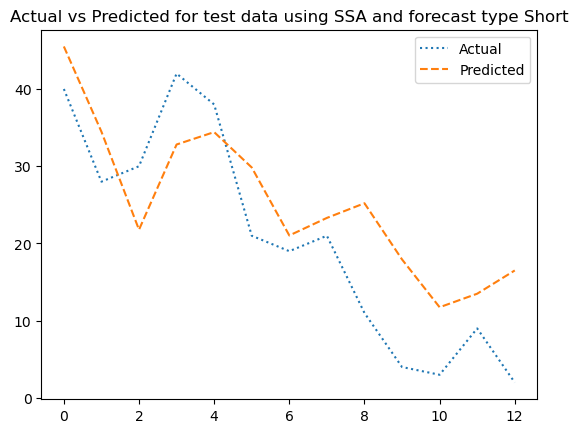

Training completed for model: time  Medium  and IMF  1
Training completed for model: time  Medium  and IMF  2
Training completed for model: time  Medium  and IMF  3
Training completed for model: time  Medium  and IMF  4
Training completed for model: time  Medium  and IMF  5
The results for forecast type  Medium  are:
        RMSE       MAE      MASE      sMAPE
0  18.297535  14.87175  1.645105  91.660593


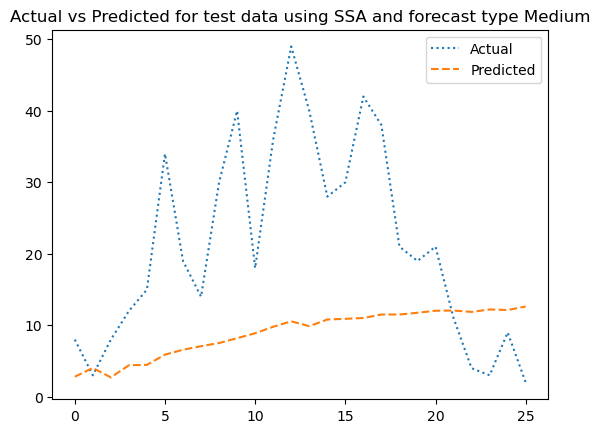

Training completed for model: time  Long  and IMF  1
Training completed for model: time  Long  and IMF  2
Training completed for model: time  Long  and IMF  3
Training completed for model: time  Long  and IMF  4
Training completed for model: time  Long  and IMF  5
The results for forecast type  Long  are:
        RMSE        MAE      MASE       sMAPE
0  21.628127  15.222834  2.929678  132.177606


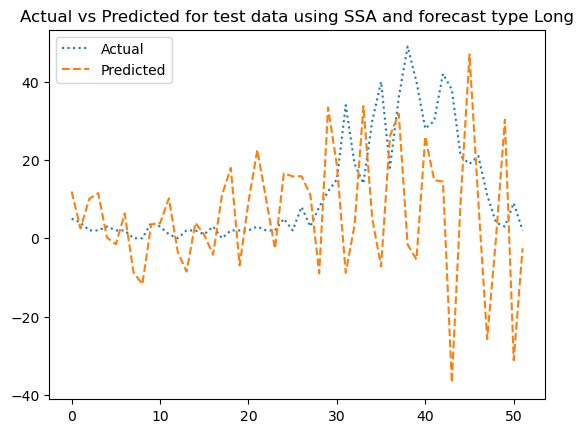

In [23]:
file_path ="Datasets/Dengue_datasets/Ahmedabad_Dengue.xlsx"
location = file_path.split("/")[-1].split("_")[0]
disease = file_path.split("/")[-1].split("_")[1].split(".")[0]
dataset = pd.read_excel(file_path)

hyperparameters = pd.read_excel("./Suggested hyper-parameter values of EWNet model.xlsx")

for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break

type_of_dataset = "Weekly"

index_of_cases = 1

for time in ["Short", "Medium", "Long"]:
    p = hyperparameters[time][hyperparameters_index]
    k = (p+1)//2

    pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
    pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}

    if type_of_dataset == "Weekly":
        pred_length = pred_length_weekly[time]
    else:
        pred_length = pred_length_monthly[time]

    test_size = pred_length
    valid_size = 2*pred_length
    train_size = dataset.shape[0] - test_size - valid_size-p

    cases_time_series = dataset.iloc[:, index_of_cases].values

    cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)

    window_size = np.floor(np.log(len(cases_time_series_scaled))).astype(int)
    ssa = SingularSpectrumAnalysis(window_size=window_size)

    IMFs = ssa.fit_transform(cases_time_series_scaled.reshape(1, -1))

    IMFs = IMFs.reshape(window_size,-1)
    n_imfs = IMFs.shape[0]

    X_train = []
    y_train = []
    X_valid = []
    y_valid = []

    for i in range(n_imfs):
        X, y = create_lagged_sequence(IMFs[i], p)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        X_train.append(X[0:train_size])
        y_train.append(y[0:train_size])
        X_valid.append(X[train_size:train_size+valid_size])
        y_valid.append(y[train_size:train_size+valid_size])

    n_models = []

    for i in range(n_imfs):

        model = EWNet(p, k)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        epochs = 10000
        print_freq = 10
        epoch_freq = epochs//print_freq
        train_losses = []
        valid_losses = []

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            y_train_pred = model(X_train[i])
            y_train_pred = y_train_pred.view(-1)
            loss = criterion(y_train_pred, y_train[i])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            with torch.no_grad():
                model.eval()
                y_valid_pred = model(X_valid[i])
                y_valid_pred = y_valid_pred.view(-1)
                valid_loss = criterion(y_valid_pred, y_valid[i])
                valid_losses.append(valid_loss.item())

        n_models.append(model)
        print("Training completed for model: time ", time, " and IMF ", i+1)

    y_test_pred_final = []

    for i in range(n_imfs):
        initial_input = IMFs[i][ -p:]
        y_test_pred_imfs = []

        model = n_models[i]
        model.eval()

        with torch.no_grad():
            for j in range(test_size):
                y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
                y_test_pred_imfs.append(y_pred.item())
                initial_input = np.append(initial_input, y_pred.item())

        y_test_pred_final.append(y_test_pred_imfs)

    y_test_pred_final = np.array(y_test_pred_final)
    y_test_pred_final = y_test_pred_final.sum(axis=0)
    y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

    y_test_pred = np.array(y_test_pred_final)
    y_test_true = np.array(cases_time_series[-test_size:])
    rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
    mae = np.mean(np.abs(y_test_pred - y_test_true))
    mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
    smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))

    results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
    print("The results for forecast type ", time, " are:")
    print(results)

    plt.plot(y_test_true, label="Actual", linestyle= "dotted")
    plt.plot(y_test_pred, label="Predicted", linestyle="--")
    plt.title("Actual vs Predicted for test data using SSA and forecast type "+time)
    plt.legend()
    plt.show()

Training completed for model: time  Short  and IMF  1
Training completed for model: time  Short  and IMF  2
Training completed for model: time  Short  and IMF  3
Training completed for model: time  Short  and IMF  4
Training completed for model: time  Short  and IMF  5
Training completed for model: time  Short  and IMF  6
The results for forecast type  Short  are:
        RMSE        MAE     MASE      sMAPE
0  43.263639  35.876697  1.77901  56.759987


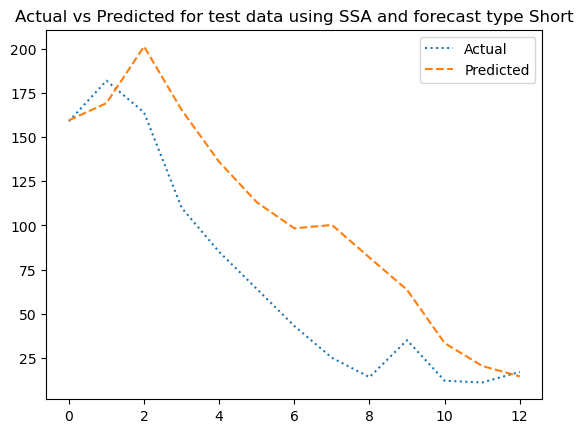

Training completed for model: time  Medium  and IMF  1
Training completed for model: time  Medium  and IMF  2
Training completed for model: time  Medium  and IMF  3
Training completed for model: time  Medium  and IMF  4
Training completed for model: time  Medium  and IMF  5
Training completed for model: time  Medium  and IMF  6
The results for forecast type  Medium  are:
         RMSE         MAE      MASE       sMAPE
0  117.881616  102.484144  4.145799  159.059448


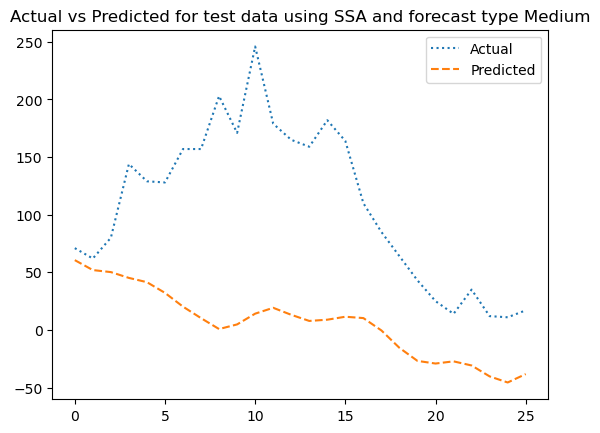

Training completed for model: time  Long  and IMF  1
Training completed for model: time  Long  and IMF  2
Training completed for model: time  Long  and IMF  3
Training completed for model: time  Long  and IMF  4
Training completed for model: time  Long  and IMF  5
Training completed for model: time  Long  and IMF  6
The results for forecast type  Long  are:
        RMSE      MAE     MASE       sMAPE
0  86.480901  60.9058  3.83481  120.155975


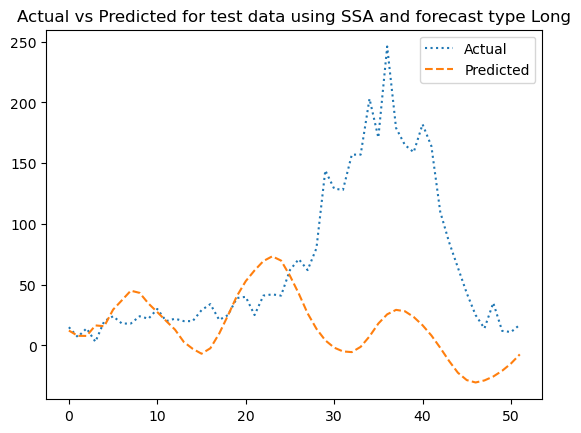

In [24]:
file_path ="Datasets/Influenza_datasets/Australia_Inflluenza.xlsx"
location = file_path.split("/")[-1].split("_")[0]
disease = file_path.split("/")[-1].split("_")[1].split(".")[0]
dataset = pd.read_excel(file_path)

hyperparameters = pd.read_excel("./Suggested hyper-parameter values of EWNet model.xlsx")

for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break

type_of_dataset = "Weekly"

index_of_cases = 1

for time in ["Short", "Medium", "Long"]:
    p = hyperparameters[time][hyperparameters_index]
    k = (p+1)//2

    pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
    pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}

    if type_of_dataset == "Weekly":
        pred_length = pred_length_weekly[time]
    else:
        pred_length = pred_length_monthly[time]

    test_size = pred_length
    valid_size = 2*pred_length
    train_size = dataset.shape[0] - test_size - valid_size-p

    cases_time_series = dataset.iloc[:, index_of_cases].values

    cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)

    window_size = np.floor(np.log(len(cases_time_series_scaled))).astype(int)
    ssa = SingularSpectrumAnalysis(window_size=window_size)

    IMFs = ssa.fit_transform(cases_time_series_scaled.reshape(1, -1))

    IMFs = IMFs.reshape(window_size,-1)
    n_imfs = IMFs.shape[0]

    X_train = []
    y_train = []
    X_valid = []
    y_valid = []

    for i in range(n_imfs):
        X, y = create_lagged_sequence(IMFs[i], p)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        X_train.append(X[0:train_size])
        y_train.append(y[0:train_size])
        X_valid.append(X[train_size:train_size+valid_size])
        y_valid.append(y[train_size:train_size+valid_size])

    n_models = []

    for i in range(n_imfs):

        model = EWNet(p, k)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        epochs = 10000
        print_freq = 10
        epoch_freq = epochs//print_freq
        train_losses = []
        valid_losses = []

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            y_train_pred = model(X_train[i])
            y_train_pred = y_train_pred.view(-1)
            loss = criterion(y_train_pred, y_train[i])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            with torch.no_grad():
                model.eval()
                y_valid_pred = model(X_valid[i])
                y_valid_pred = y_valid_pred.view(-1)
                valid_loss = criterion(y_valid_pred, y_valid[i])
                valid_losses.append(valid_loss.item())

        n_models.append(model)
        print("Training completed for model: time ", time, " and IMF ", i+1)

    y_test_pred_final = []

    for i in range(n_imfs):
        initial_input = IMFs[i][ -p:]
        y_test_pred_imfs = []

        model = n_models[i]
        model.eval()

        with torch.no_grad():
            for j in range(test_size):
                y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
                y_test_pred_imfs.append(y_pred.item())
                initial_input = np.append(initial_input, y_pred.item())

        y_test_pred_final.append(y_test_pred_imfs)

    y_test_pred_final = np.array(y_test_pred_final)
    y_test_pred_final = y_test_pred_final.sum(axis=0)
    y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

    y_test_pred = np.array(y_test_pred_final)
    y_test_true = np.array(cases_time_series[-test_size:])
    rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
    mae = np.mean(np.abs(y_test_pred - y_test_true))
    mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
    smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))

    results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
    print("The results for forecast type ", time, " are:")
    print(results)

    plt.plot(y_test_true, label="Actual", linestyle= "dotted")
    plt.plot(y_test_pred, label="Predicted", linestyle="--")
    plt.title("Actual vs Predicted for test data using SSA and forecast type "+time)
    plt.legend()
    plt.show()

Training completed for model: time  Short  and IMF  1
Training completed for model: time  Short  and IMF  2
Training completed for model: time  Short  and IMF  3
Training completed for model: time  Short  and IMF  4
The results for forecast type  Short  are:
         RMSE          MAE      MASE     sMAPE
0  6020.01388  5337.195103  0.717751  5.531585


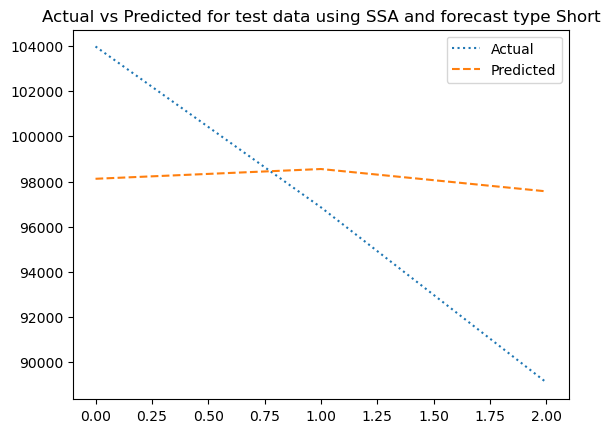

Training completed for model: time  Medium  and IMF  1
Training completed for model: time  Medium  and IMF  2
Training completed for model: time  Medium  and IMF  3
Training completed for model: time  Medium  and IMF  4
The results for forecast type  Medium  are:
          RMSE          MAE      MASE     sMAPE
0  4562.707589  3506.979666  0.742061  3.605742


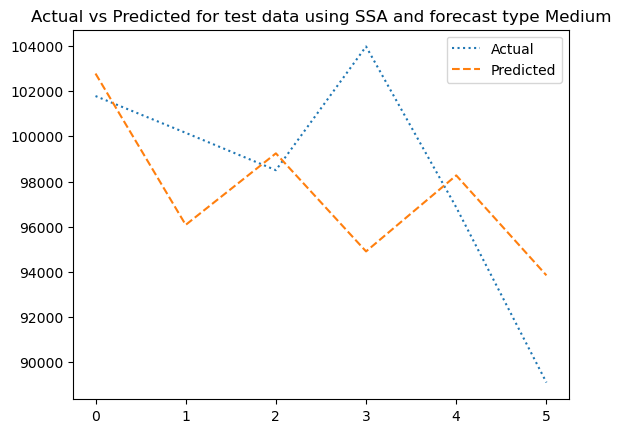

Training completed for model: time  Long  and IMF  1
Training completed for model: time  Long  and IMF  2
Training completed for model: time  Long  and IMF  3
Training completed for model: time  Long  and IMF  4
The results for forecast type  Long  are:
           RMSE           MAE      MASE      sMAPE
0  12175.556356  10934.604867  1.749155  10.563544


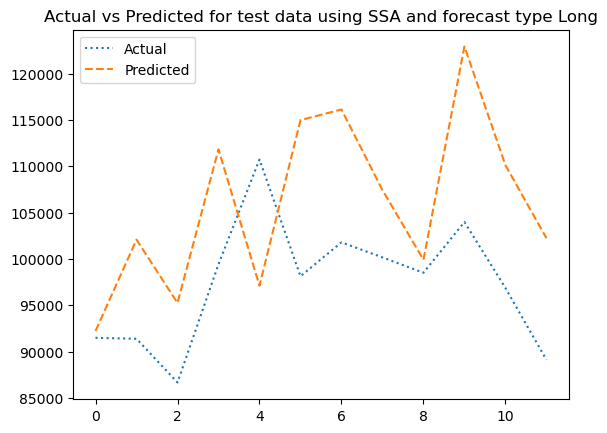

In [25]:
file_path ="Datasets/Hepatitis_dataset/China_Hepatitis_B.xlsx"
location = file_path.split("/")[-1].split("_")[0]
disease = file_path.split("/")[-1].split("_")[1].split(".")[0]
dataset = pd.read_excel(file_path)

hyperparameters = pd.read_excel("./Suggested hyper-parameter values of EWNet model.xlsx")

for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break

type_of_dataset = "Monthly"

index_of_cases = 1

for time in ["Short", "Medium", "Long"]:
    p = hyperparameters[time][hyperparameters_index]
    k = (p+1)//2

    pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
    pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}

    if type_of_dataset == "Weekly":
        pred_length = pred_length_weekly[time]
    else:
        pred_length = pred_length_monthly[time]

    test_size = pred_length
    valid_size = 2*pred_length
    train_size = dataset.shape[0] - test_size - valid_size-p

    cases_time_series = dataset.iloc[:, index_of_cases].values

    cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)

    window_size = np.floor(np.log(len(cases_time_series_scaled))).astype(int)
    ssa = SingularSpectrumAnalysis(window_size=window_size)

    IMFs = ssa.fit_transform(cases_time_series_scaled.reshape(1, -1))

    IMFs = IMFs.reshape(window_size,-1)
    n_imfs = IMFs.shape[0]

    X_train = []
    y_train = []
    X_valid = []
    y_valid = []

    for i in range(n_imfs):
        X, y = create_lagged_sequence(IMFs[i], p)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        X_train.append(X[0:train_size])
        y_train.append(y[0:train_size])
        X_valid.append(X[train_size:train_size+valid_size])
        y_valid.append(y[train_size:train_size+valid_size])

    n_models = []

    for i in range(n_imfs):

        model = EWNet(p, k)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        epochs = 10000
        print_freq = 10
        epoch_freq = epochs//print_freq
        train_losses = []
        valid_losses = []

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            y_train_pred = model(X_train[i])
            y_train_pred = y_train_pred.view(-1)
            loss = criterion(y_train_pred, y_train[i])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            with torch.no_grad():
                model.eval()
                y_valid_pred = model(X_valid[i])
                y_valid_pred = y_valid_pred.view(-1)
                valid_loss = criterion(y_valid_pred, y_valid[i])
                valid_losses.append(valid_loss.item())

        n_models.append(model)
        print("Training completed for model: time ", time, " and IMF ", i+1)

    y_test_pred_final = []

    for i in range(n_imfs):
        initial_input = IMFs[i][ -p:]
        y_test_pred_imfs = []

        model = n_models[i]
        model.eval()

        with torch.no_grad():
            for j in range(test_size):
                y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
                y_test_pred_imfs.append(y_pred.item())
                initial_input = np.append(initial_input, y_pred.item())

        y_test_pred_final.append(y_test_pred_imfs)

    y_test_pred_final = np.array(y_test_pred_final)
    y_test_pred_final = y_test_pred_final.sum(axis=0)
    y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

    y_test_pred = np.array(y_test_pred_final)
    y_test_true = np.array(cases_time_series[-test_size:])
    rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
    mae = np.mean(np.abs(y_test_pred - y_test_true))
    mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
    smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))

    results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
    print("The results for forecast type ", time, " are:")
    print(results)

    plt.plot(y_test_true, label="Actual", linestyle= "dotted")
    plt.plot(y_test_pred, label="Predicted", linestyle="--")
    plt.title("Actual vs Predicted for test data using SSA and forecast type "+time)
    plt.legend()
    plt.show()